# Time Series of YCSD Covid Case Metric

This notebook examines the time series of the York County COVID Cases ostensibly used by YCSD to make decisions about school reopenings.

* YCSD presents there metrics on https://ycsd.yorkcountyschools.org/domain/1313
* VDH represents the this number for the localities on https://www.vdh.virginia.gov/coronavirus/coronavirus/covid-19-in-virginia-locality/ and on https://www.vdh.virginia.gov/coronavirus/key-measures/pandemic-metrics/school-metrics/ under the localities tab
* VDH shares the data at https://data.virginia.gov/Government/VDH-COVID-19-PublicUseDataset-Cases/bre9-aqqr
* I'm sharing This notebook in Github at https://github.com/drf5n/YCSD_covid_metrics and https://github.com/drf5n/YCSD_covid_metrics/blob/master/YorkCountyCovidMetric.ipynb

-- David Forrest 2020-12-04


In [1]:
# %matplotlib widget
import os,sys,io, time, pathlib
import pandas as pd
#import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt

import bokeh.plotting
import bokeh.io
import bokeh.models
from bokeh.io import output_notebook
bokeh.io.output_notebook()

Loading BokehJS ...

In [2]:
def file_age(filepath):
    return time.time() - os.path.getmtime(filepath)


In [3]:
# get the Virginia COVID Case data from https://data.virginia.gov/Government/VDH-COVID-19-PublicUseDataset-Cases/bre9-aqqr

df_name = "VA_vdh_casedata.csv"
if file_age(df_name) > 86400/2:
    !wget -O $df_name 'https://data.virginia.gov/api/views/bre9-aqqr/rows.csv?accessType=DOWNLOAD'
    pathlib.Path(df_name).touch()

--2020-12-16 11:11:20--  https://data.virginia.gov/api/views/bre9-aqqr/rows.csv?accessType=DOWNLOAD
Resolving data.virginia.gov (data.virginia.gov)... 52.206.140.199, 52.206.68.26, 52.206.140.205
Connecting to data.virginia.gov (data.virginia.gov)|52.206.140.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘VA_vdh_casedata.csv’

VA_vdh_casedata.csv     [    <=>             ]   1.70M  1.62MB/s    in 1.1s    

2020-12-16 11:11:25 (1.62 MB/s) - ‘VA_vdh_casedata.csv’ saved [1784319]



In [4]:
df=pd.read_csv(df_name)
df["date"] = pd.to_datetime(df['Report Date'])

df.tail()

,Report Date,FIPS,Locality,VDH Health District,Total Cases,Hospitalizations,Deaths,date
36570,12/16/2020,51800,Suffolk,Western Tidewater,3312,207,87,2020-12-16
36571,12/16/2020,51810,Virginia Beach,Virginia Beach,13452,644,129,2020-12-16
36572,12/16/2020,51820,Waynesboro,Central Shenandoah,912,28,10,2020-12-16
36573,12/16/2020,51830,Williamsburg,Peninsula,338,22,8,2020-12-16
36574,12/16/2020,51840,Winchester,Lord Fairfax,1379,70,6,2020-12-16


In [5]:

df = df.sort_values(by=['Locality', 'VDH Health District', 'date'])
display(df.head())

df['TC_diff']= df.groupby('Locality')['Total Cases'].diff().fillna(0)
df['TC_sum14']= df.groupby('Locality')['Total Cases'].diff(14).fillna(0)

display(df.tail())



,Report Date,FIPS,Locality,VDH Health District,Total Cases,Hospitalizations,Deaths,date
0,03/17/2020,51001,Accomack,Eastern Shore,0,0,0,2020-03-17
133,03/18/2020,51001,Accomack,Eastern Shore,0,0,0,2020-03-18
266,03/19/2020,51001,Accomack,Eastern Shore,0,0,0,2020-03-19
399,03/20/2020,51001,Accomack,Eastern Shore,1,0,0,2020-03-20
532,03/21/2020,51001,Accomack,Eastern Shore,1,0,0,2020-03-21


,Report Date,FIPS,Locality,VDH Health District,Total Cases,Hospitalizations,Deaths,date,TC_diff,TC_sum14
36004,12/12/2020,51199,York,Peninsula,1069,32,9,2020-12-12,23.0,180.0
36137,12/13/2020,51199,York,Peninsula,1089,32,9,2020-12-13,20.0,181.0
36270,12/14/2020,51199,York,Peninsula,1105,32,9,2020-12-14,16.0,184.0
36403,12/15/2020,51199,York,Peninsula,1129,32,9,2020-12-15,24.0,200.0
36536,12/16/2020,51199,York,Peninsula,1159,32,9,2020-12-16,30.0,209.0


In [73]:
popxls=pd.read_excel('/Users/drf/Downloads/2018 Pop.xls',header=[3])
popxls['FIPS']=51000+(popxls.loc[:,'Code'].fillna(0)).astype(int)  # eliminate NaNs above?
display(popxls[popxls['Code']==810]['Population'])
display(popxls['Locality'].str.match('York County').fillna(False))
display(popxls[popxls['Locality'].str.match('York County').fillna(False)])
display(popxls[popxls['Locality'].str.contains('Virginia Beach').fillna(False)])
display(popxls[popxls['Locality'].str.contains('City').fillna(False)])


124    450189.0
Name: Population, dtype: float64

0      False
1      False
2      False
3      False
4      False
       ...  
130    False
131    False
132    False
133    False
134    False
Name: Locality, Length: 135, dtype: bool

,Code,Region,District,Locality,Population,0,1-4,5-9,10-14,15-17,...,20-24.1,25-34,35-44,45-54,55-64,65-74,75-84,85+,0,FIPS
126,199.0,5.0,21.0,York County ...,67846.0,640.0,3151.0,4480.0,4823.0,3062.0,...,4240.0,7876.0,8869.0,8805.0,9284.0,6311.0,3428.0,1218.0,640.0,51199


,Code,Region,District,Locality,Population,0,1-4,5-9,10-14,15-17,...,20-24.1,25-34,35-44,45-54,55-64,65-74,75-84,85+,0,FIPS
124,810.0,5.0,20.0,Virginia Beach City ...,450189.0,5609.0,22638.0,27497.0,27714.0,16115.0,...,31409.0,74440.0,59481.0,55457.0,55664.0,37719.0,18653.0,7632.0,5609.0,51810


,Code,Region,District,Locality,Population,0,1-4,5-9,10-14,15-17,...,20-24.1,25-34,35-44,45-54,55-64,65-74,75-84,85+,0,FIPS
3,720.0,3.0,1.0,Norton City ...,3968.0,28.0,173.0,246.0,203.0,143.0,...,252.0,608.0,480.0,470.0,530.0,400.0,246.0,94.0,28.0,51720
14,520.0,3.0,3.0,Bristol City ...,16482.0,138.0,713.0,886.0,991.0,595.0,...,809.0,2139.0,2044.0,2167.0,2232.0,1907.0,1150.0,419.0,138.0,51520
15,640.0,3.0,3.0,Galax City ...,6423.0,49.0,261.0,448.0,406.0,239.0,...,390.0,777.0,665.0,891.0,854.0,652.0,381.0,261.0,49.0,51640
20,750.0,3.0,4.0,Radford City ...,18339.0,139.0,508.0,629.0,601.0,408.0,...,4650.0,2279.0,1562.0,1690.0,1631.0,941.0,504.0,227.0,139.0,51750
25,580.0,3.0,5.0,Covington City ...,5460.0,0.0,130.0,325.0,323.0,204.0,...,333.0,700.0,601.0,736.0,829.0,661.0,365.0,134.0,0.0,51580
26,770.0,3.0,5.0,Roanoke City ...,99920.0,1477.0,5577.0,6340.0,5973.0,3170.0,...,5670.0,15480.0,12241.0,12533.0,13136.0,9796.0,4335.0,2389.0,1477.0,51770
27,775.0,3.0,5.0,Salem City ...,25643.0,291.0,1104.0,1345.0,1402.0,973.0,...,2063.0,2955.0,2738.0,3273.0,3484.0,2717.0,1461.0,658.0,291.0,51775
33,530.0,1.0,6.0,Buena Vista City ...,6237.0,2.0,163.0,346.0,358.0,219.0,...,611.0,797.0,657.0,741.0,791.0,681.0,396.0,142.0,2.0,51530
34,660.0,1.0,6.0,Harrisonburg City ...,54033.0,687.0,2380.0,2425.0,2373.0,1315.0,...,11013.0,7708.0,5897.0,4697.0,4226.0,2807.0,1456.0,821.0,687.0,51660
35,678.0,1.0,6.0,Lexington City ...,7136.0,6.0,95.0,213.0,219.0,136.0,...,1929.0,582.0,490.0,468.0,534.0,602.0,360.0,194.0,6.0,51678


In [52]:
# subset for York and normalize per capita
loi='York'

dfy = df[df['Locality']=='York'].copy()
dfy['per100k_14daysum']=dfy['TC_sum14']*100000/68280  

# for VB:

if 0:
    loi='Virginia Beach'

    dfy = df[df['Locality']=='Virginia Beach'].copy()
    dfy['per100k_14daysum']=dfy['TC_sum14']*100000/450189  


In [53]:
dfy.tail(30)

,Report Date,FIPS,Locality,VDH Health District,Total Cases,Hospitalizations,Deaths,date,TC_diff,TC_sum14,per100k_14daysum
32714,11/17/2020,51810,Virginia Beach,Virginia Beach,9449,478,111,2020-11-17,65.0,1098.0,243.897563
32847,11/18/2020,51810,Virginia Beach,Virginia Beach,9533,483,111,2020-11-18,84.0,1114.0,247.451626
32980,11/19/2020,51810,Virginia Beach,Virginia Beach,9614,496,112,2020-11-19,81.0,1147.0,254.781880
33113,11/20/2020,51810,Virginia Beach,Virginia Beach,9716,500,112,2020-11-20,102.0,1176.0,261.223619
33246,11/21/2020,51810,Virginia Beach,Virginia Beach,9865,507,112,2020-11-21,149.0,1234.0,274.107097
33379,11/22/2020,51810,Virginia Beach,Virginia Beach,9992,507,112,2020-11-22,127.0,1294.0,287.434833
33512,11/23/2020,51810,Virginia Beach,Virginia Beach,10168,507,112,2020-11-23,176.0,1431.0,317.866496
33645,11/24/2020,51810,Virginia Beach,Virginia Beach,10279,518,112,2020-11-24,111.0,1469.0,326.307395
33778,11/25/2020,51810,Virginia Beach,Virginia Beach,10387,526,113,2020-11-25,108.0,1523.0,338.302357
33911,11/26/2020,51810,Virginia Beach,Virginia Beach,10474,526,113,2020-11-26,87.0,1510.0,335.414681


<AxesSubplot:title={'center':'York County Number of new cases per 100,000 persons \nwithin the last 14 days'}, xlabel='date'>

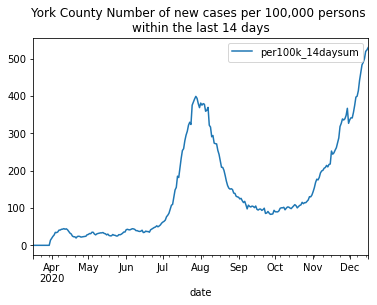

In [46]:
ph = dfy.plot(y='per100k_14daysum',x='date',title="York County Number of new cases per 100,000 persons \nwithin the last 14 days")

ph

<AxesSubplot:title={'center':'York County Cases, 14 day sum, per 100K'}, xlabel='date'>

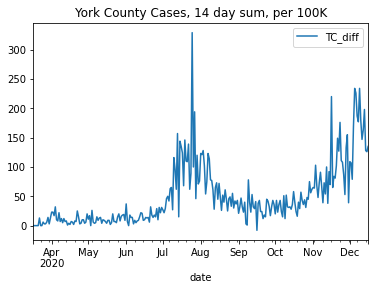

In [47]:
ph = dfy.plot(y='TC_diff',x='date',title="York County Cases, 14 day sum, per 100K")
ph

In [54]:
TOOLTIPS = [
 #   ("index", "$index"),
 #   ("date:", "$x{%F %T}"),
    ("date:", "@date{%F}"),
    ("cases/14d/100k:","@per100k_14daysum"),
 #   ("(x,y)", "($x, $y)"),
]


#p=bokeh.plotting.figure( tooltips=TOOLTIPS, x_axis_type='datetime')
p=bokeh.plotting.figure( x_axis_type='datetime',y_range=(0,550),
#                        tooltips=TOOLTIPS,formatters={"$x": "datetime"},
                        title="{} Number of new cases per 100,000 persons within the last 14 days".format(loi))

    
hth = bokeh.models.HoverTool(tooltips=TOOLTIPS,
                             formatters={"$x": "datetime",
                                        "@date": "datetime"
                                        },
                             mode='vline',
                            )

print(hth)
print(hth.formatters)
p.add_tools(hth)
#hover = p.select(dict(type=bokeh.models.HoverTool))


#hover(tooltips=TOOLTIPS,
#)

p.add_layout(bokeh.models.BoxAnnotation(bottom=0,top=5, fill_alpha=0.4, fill_color='teal'))
p.add_layout(bokeh.models.BoxAnnotation(bottom=5,top=20, fill_alpha=0.4, fill_color='lightgreen'))
p.add_layout(bokeh.models.BoxAnnotation(bottom=20,top=50, fill_alpha=0.4, fill_color='yellow'))
p.add_layout(bokeh.models.BoxAnnotation(bottom=50,top=200, fill_alpha=0.4, fill_color='orange'))
p.add_layout(bokeh.models.BoxAnnotation(bottom=200, fill_alpha=0.4, fill_color='red'))



#p.line(dfy['date'],dfy['per100k_14daysum'])
p.line(x='date', y='per100k_14daysum',source=dfy)
#p.title()

#?p.line

HoverTool(id='3883', ...)
{'$x': 'datetime', '@date': 'datetime'}


GlyphRenderer(id='3894', ...)

In [55]:
bokeh.plotting.show(p)

In [12]:
bokeh.plotting.output_file('docs/YorkCountyCovidMetric_plot.html', mode='inline')
bokeh.plotting.save(p)

# needs geckodriver  -- have it in conda env py3plot
bokeh.io.export_png(p, filename="docs/YorkCountyCovidMetric_plot.png")



'/Users/drf/2020/Home/School/YCSD_covid_metrics/docs/YorkCountyCovidMetric_plot.png'

In [19]:
# Save notebook as a python script:
# ! jupyter nbconvert --to script *.ipynb